# Modelo SARIMAX



In [76]:
import os
# os.environ["SM_FRAMEWORK"] = "tf.keras"
import pathlib
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# import seaborn as sns
import datetime as dt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Flatten, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

In [77]:
#Conexión de google drive con el repo
# from google.colab import drive
# drive.mount('/content/drive')
# ruta = os.path.join("/content/drive/MyDrive","MonografiaUdeA")
# os.chdir(ruta)
##==========================
abspath = pathlib.Path.cwd()
print(f"Directorio de trabajo: {abspath}")
###==========================

Directorio de trabajo: d:\Repos_\MonografiaUdeA


In [78]:
modelo_implementar = ['SARIMAX']

def parse(x):
    return dt.datetime.strptime(x, '%Y-%m-%d')
dataset = pd.read_csv(os.path.join(abspath,"datasets", "procesado", "3_dataset_filtrado.csv"), index_col=0, date_parser=parse)
df = dataset.copy()#.iloc[:,[0]].reset_index()
df = df[['precio_bolsa', 'precio_oferta']].reset_index()

In [79]:
df['fecha'] = pd.to_datetime(df['fecha'])
df.set_index('fecha', inplace=True)
df.head()

,precio_bolsa,precio_oferta
fecha,,
2010-01-01,120.501228,267.437633
2010-01-02,118.495340,277.153592
2010-01-03,121.160145,313.552755
2010-01-04,123.962937,303.519878
2010-01-05,120.666437,339.600449


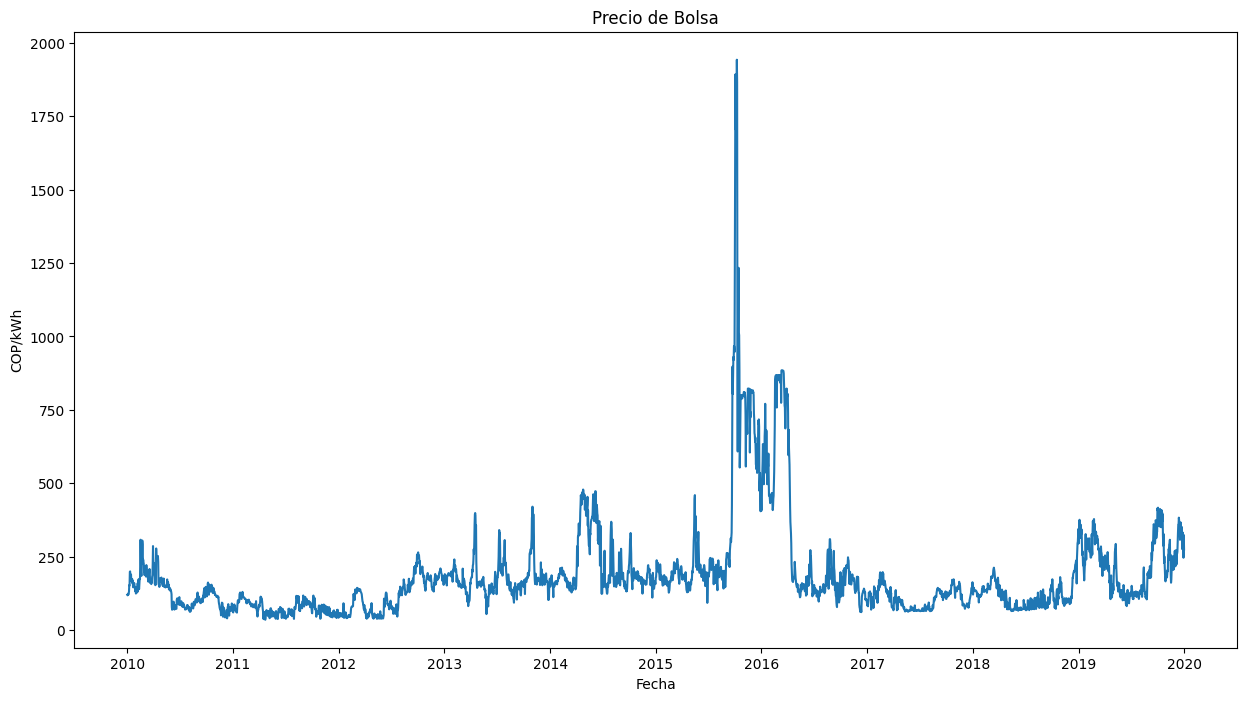

In [80]:
# Plot the time series
plt.figure(figsize = (15,8))
plt.plot(df['precio_bolsa'])
plt.title('Precio de Bolsa')
plt.xlabel('Fecha')
plt.ylabel('COP/kWh')
plt.show()

## Validación de estacionariedad

In [81]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['precio_bolsa'])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.436130
p-value: 0.000256


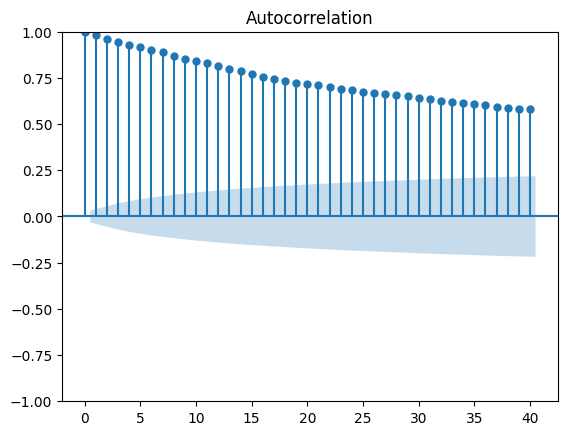

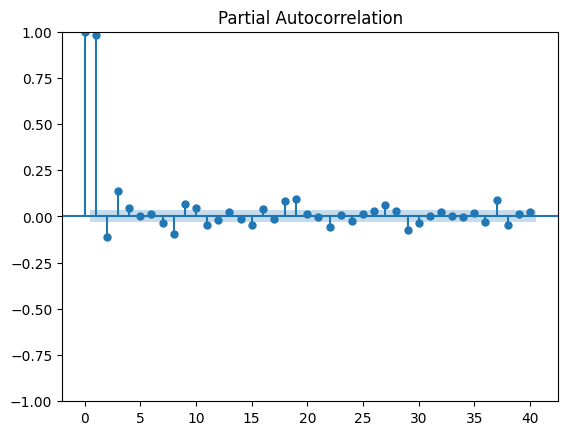

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['precio_bolsa'], lags=40)
plot_pacf(df['precio_bolsa'], lags=40)
plt.show()

Un valor p inferior a 0,05 indica estacionariedad y nuestros datos cumplen con este criterio, por lo que no es necesario realizar diferenciación.

In [83]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# model = ARIMA(df['precio_bolsa'], order=(1, 0, 1))
# model_fit = model.fit()

In [84]:
# forecast = model_fit.get_forecast(steps=30)

In [85]:
from sklearn.metrics import mean_squared_error

def sarimax_model (df, p, d , q , P , D , Q , s , train_porc = 0.8):
    train_size = int(len(df) * train_porc)+1
    train, test = df[0:train_size], df[train_size:len(df)]

    model_train = SARIMAX(train['precio_bolsa'], order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_train_fit = model_train.fit()

    test_forecast = model_train_fit.get_forecast(steps=len(test))
    test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)
    mae = mean_absolute_error(test['precio_bolsa'], test_forecast_series)
    mse = mean_squared_error(test['precio_bolsa'], test_forecast_series)
    mape = mean_absolute_percentage_error(test['precio_bolsa'], test_forecast_series)
    rmse = mse**0.5

    return (mae, mse, rmse, mape, model_train_fit)

In [86]:
from itertools import product

p_values = range(1, 3)
d_values = range(0, 1)
q_values = range(1, 3)
P_values = range(1, 3)
D_values = range(0, 1)
Q_values = range(1, 3)
s_values = [12]
combinacion_parametros = list(product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

In [87]:
import warnings
warnings.filterwarnings("ignore")
def get_best_model(df, combinacion_parametros):
    best_score = float("inf")
    best_params = []
    for element in combinacion_parametros:
        p, d, q, P, D, Q, s = element
        mae, mse, rmse, mape, model = sarimax_model(df,p = p, d = d, q = q, P = P, D = D, Q = Q, s=s)
        print(element, mse)
        if mse < best_score:
            best_score, best_params = mse, element

    return mae, mse, rmse, mape, best_params, model

mae, mse, rmse, mape, best_params, SARIMAX_model = get_best_model(df, combinacion_parametros)

(1, 0, 1, 1, 0, 1, 12) 34007.33707512263
(1, 0, 1, 1, 0, 2, 12) 33983.37133933197
(1, 0, 1, 2, 0, 1, 12) 33766.98992360579
(1, 0, 1, 2, 0, 2, 12) 33580.69386189136
(1, 0, 2, 1, 0, 1, 12) 32594.24854796078
(1, 0, 2, 1, 0, 2, 12) 32738.671497226664
(1, 0, 2, 2, 0, 1, 12) 32735.264571238375
(1, 0, 2, 2, 0, 2, 12) 31898.104496686577
(2, 0, 1, 1, 0, 1, 12) 33680.011554546174
(2, 0, 1, 1, 0, 2, 12) 32515.81786125504
(2, 0, 1, 2, 0, 1, 12) 35552.236885369995
(2, 0, 1, 2, 0, 2, 12) 34870.0598482606
(2, 0, 2, 1, 0, 1, 12) 30961.659842408495
(2, 0, 2, 1, 0, 2, 12) 30794.42792291145
(2, 0, 2, 2, 0, 1, 12) 30763.03003042968
(2, 0, 2, 2, 0, 2, 12) 30755.66384495593


In [88]:
import pickle
with open(os.path.join(abspath,"models", "iterations",modelo_implementar[0], "model.pkl"),'wb') as f:
    pickle.dump(SARIMAX_model,f)

In [89]:
with open(os.path.join(abspath,"models", "iterations",modelo_implementar[0], "model.pkl"),'rb') as f:
    mp = pickle.load(f)

In [90]:
mp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       precio_bolsa   No. Observations:                 2922
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 12)   Log Likelihood              -14404.186
Date:                            Thu, 20 Jun 2024   AIC                          28826.372
Time:                                    15:27:13   BIC                          28880.192
Sample:                                01-01-2010   HQIC                         28845.757
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4280      0.040     35.272      0.000       1.349       1.507
ar.L2         -0.4310      0.040    -10.798      0.000      -0.509      -0.353
ma.L1         -0.2942      0.041     -7.190      0.000      -0.374      -0.214
ma.L2         -0.1916      0.006    -30.179      0.000      -0.204      -0.179
ar.S.L12       0.9942      0.133      7.471      0.000       0.733       1.255
ar.S.L24      -0.6032      0.099     -6.101      0.000      -0.797      -0.409
ma.S.L12      -1.0144      0.138     -7.370      0.000      -1.284      -0.745
ma.S.L24       0.5649      0.109      5.200      0.000       0.352       0.778
sigma2      1110.6586      5.283    210.216      0.000    1100.303    1121.014
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):           3436331.97
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              13.50   Skew:                            -4.86
Prob(H) (two-sided):                  0.00   Kurtosis:                       170.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
train_porc = 0.8
train_size = int(len(df) * train_porc)+1
train, test = df[0:train_size], df[train_size:len(df)]
y_pred = mp.get_forecast(steps=730).predicted_mean

In [92]:
# !pip install pydataxm
import pydataxm
from pydataxm.pydataxm import ReadDB
consult = ReadDB()

In [93]:
precio_bolsa = consult.request_data("PrecBolsNaci", "Sistema", dt.date(2018, 1, 1), dt.date(2018, 1, 31) )
hours = [f"Values_Hour{str(i).zfill(2)}" for i in range(1,25)]
precio_bolsa['precio_bolsa'] = precio_bolsa[hours].mean(axis=1)
precio_bolsa = precio_bolsa.groupby('Date')['precio_bolsa'].mean().reset_index()
precio_bolsa = precio_bolsa[ ['Date'] + ['precio_bolsa']]
precio_bolsa = precio_bolsa.rename(columns = {'Date': 'fecha'}).sort_values(by = 'fecha', ascending = True).reset_index(drop = True)
precio_bolsa['fecha'] = pd.to_datetime(precio_bolsa['fecha'])
precio_bolsa = precio_bolsa.set_index('fecha')
precio_bolsa.to_csv(os.path.join(abspath,"datasets", "procesado","precio_bolsa_ene_2020.csv"), index=True)

In [94]:
precio_bolsa_pronosticado = pd.DataFrame(pd.Series(y_pred))
precio_bolsa_pronosticado.columns = ['precio_bolsa_pronosticado']
df_final = pd.merge(precio_bolsa,precio_bolsa_pronosticado, how = 'left', left_index = True, right_index=True)
df_final.head()

,precio_bolsa,precio_bolsa_pronosticado
fecha,,
2018-01-01,121.032082,145.985024
2018-01-02,136.319515,145.068531
2018-01-03,135.042328,144.321604
2018-01-04,144.265848,143.344593
2018-01-05,136.401503,143.267830


In [95]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

element_to_predict = 31
mse = mean_squared_error(df_final["precio_bolsa"][:int(element_to_predict)], df_final["precio_bolsa_pronosticado"][:int(element_to_predict)])
mae = mean_absolute_error(df_final["precio_bolsa"][:int(element_to_predict)], df_final["precio_bolsa_pronosticado"][:int(element_to_predict)])
rmse = mean_squared_error(df_final["precio_bolsa"][:int(element_to_predict)], df_final["precio_bolsa_pronosticado"][:int(element_to_predict)], squared=False)
mape = mean_absolute_percentage_error(df_final["precio_bolsa"][:int(element_to_predict)], df_final["precio_bolsa_pronosticado"][:int(element_to_predict)])
print("mse", mse.round(3))
print("mae", mae.round(3))
print("rmse", rmse.round(3))
print("mape", mape.round(3))

mse 123.375
mae 8.784
rmse 11.107
mape 7.423


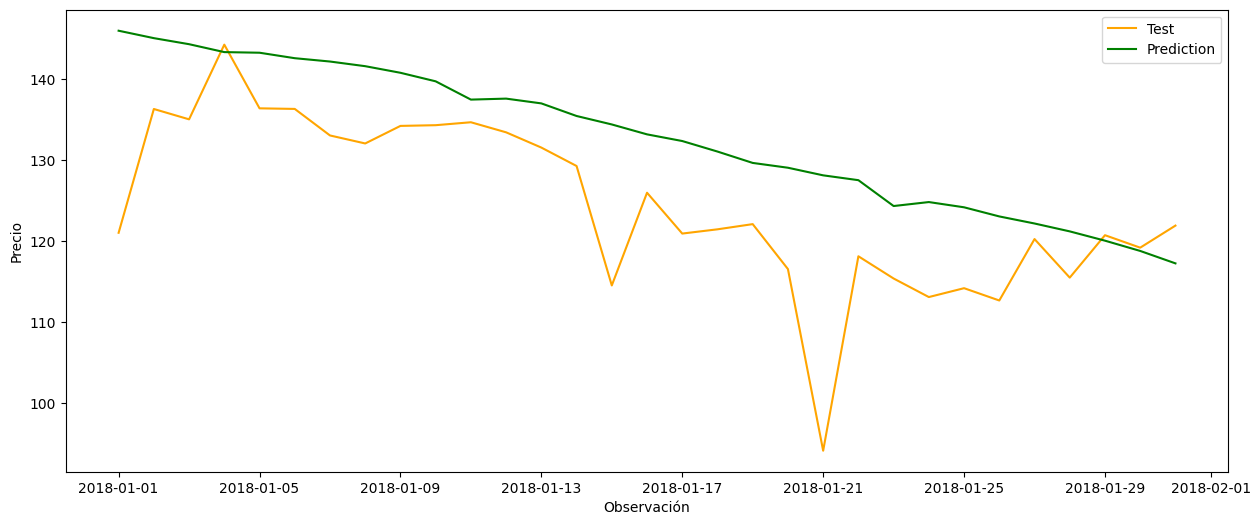

In [96]:
plt.figure(figsize=(15,6))
# plt.plot(df_final["precio_bolsa"], label='Train', color='blue')
plt.plot(test.iloc[:, 0][:31], label='Test', color='orange')
plt.plot(y_pred[:31], label='Prediction', color='green')
# plt.xticks(fechas)
plt.xlabel('Observación')
plt.ylabel('Precio')
plt.legend()
plt.show()